In [31]:
# Name: Carlos Sanchez
# Student ID: 21111910

# Exercise 4

## Data exploration

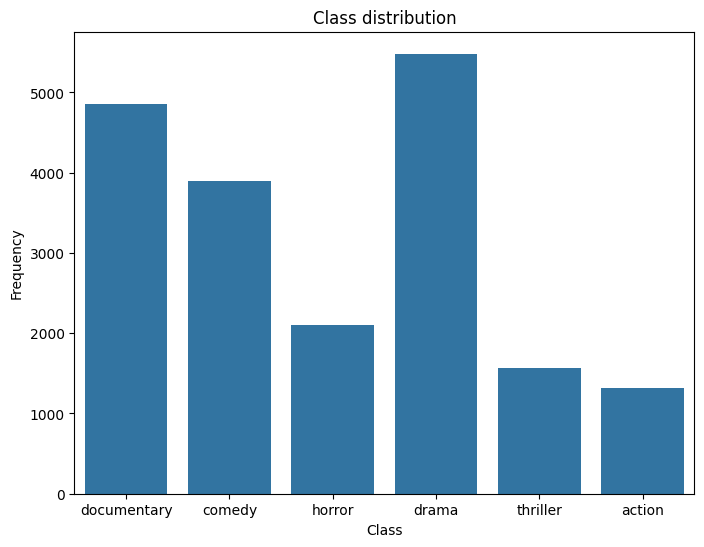

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import torch

file_path = 'train.csv'
data = pd.read_csv(file_path)

disp_np = data.to_numpy()

Xtrain, ytrain = [], []
for x in disp_np:
    lista = list()
    for i in range(len(x)):
        if i < (len(x)-1):
            lista.append(x[i])
        else:
            Xtrain.append(lista)
            ytrain.append(x[i])

plt.figure(figsize=(8, 6))
sns.countplot(x=ytrain)
plt.title('Class distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()


We can see that there are classes with a lot less values than other ones, so it is unbalanced. We have to be aware of this, because it can make the most repeated classes to seem more important and then the model would classify more than it should to this classes. Also, it can be that all values follow the same pattern, so not balancing all classes the same could help. We will try this changes more deeper in the excercise.

In [33]:
file_path = 'validate.csv'
data = pd.read_csv(file_path)

disp_np = data.to_numpy()

Xval, yval = [], []
for x in disp_np:
    lista = list()
    for i in range(len(x)):
        if i < (len(x)-1):
            lista.append(x[i])
        else:
            Xval.append(lista)
            yval.append(x[i])

In [34]:
file_path = 'test.csv'
data = pd.read_csv(file_path)

test = torch.tensor(data.iloc[:,1:].values, dtype = torch.float)

## Data pre-processing

In [35]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float)
        self.y = torch.tensor(self.__tokenize__(y), dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

    def __tokenize__(self,data):
        tokens = {
                'action': 1,
                'comedy': 2,
                'documentary': 3,
                'drama': 4,
                'horror': 5,
                'thriller': 6
            }
        tokenized = list()
        for i in data:
          tokenized.append(tokens[i])
        return tokenized

train = CustomDataset(Xtrain,ytrain)
val = CustomDataset(Xval,yval)

## Setting up Neural Network

> Añadir blockquote



In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import torch.nn.functional

class NNClassifier(nn.Module):
    def __init__(self, layers, nodes, epochs):
        super().__init__()
        self.epochs = epochs

        structure = []

        structure.append(nn.Linear(300, nodes))
        structure.append(nn.ReLU())

        for i in range(layers):
          structure.append(nn.Linear(nodes, nodes))
          structure.append(nn.ReLU())

        structure.append(nn.Linear(nodes, 6))
        self.model = nn.Sequential(*structure)

    def forward(self, x):
        x = self.model(x)
        return x

    def train_data(self):
        loss_fn = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        batch_size = math.ceil(len(train) / self.epochs)
        train_dl = DataLoader(train,batch_size)

        list_loss = []
        list_val = []
        self.train()
        for i in range(self.epochs):
            loss = 0

            for d,lb in train_dl:
              optimizer.zero_grad()

              pred = self.model(d)
              loss_i = loss_fn(pred, lb-1)
              loss_i.backward()
              optimizer.step()
              loss += loss_i.item() * d.size(0)

            loss = loss / len(train_dl.dataset)
            list_loss.append(loss)

            loss = 0

            batch_size = math.ceil(len(val) / self.epochs)
            val_dl = DataLoader(val,batch_size)

            for d,lb in val_dl:
              optimizer.zero_grad()

              pred = self(d)
              loss_i = loss_fn(pred, lb-1)
              loss_i.backward()
              optimizer.step()
              loss += loss_i.item() * d.size(0)

            loss = loss / len(val_dl.dataset)
            list_val.append(loss)

        plt.plot(list_loss, label='Training Loss')
        plt.plot(list_val, label='Validate Loss')
        plt.ylabel('Loss')
        plt.title('Loss values while training')
        plt.legend()
        plt.show()


    def predict(self,data):
        with torch.no_grad():
          y_pred = self(data)
          prob = torch.nn.functional.softmax(y_pred, dim=1)

          a, y_pred_prev = torch.max(prob, 1)
          y_pred = []

          for x in y_pred_prev:
              y_pred.append(x + 1)

        return y_pred

### Model with 1 hiden layer and 64 nodes

In [37]:
model = NNClassifier(1,64,100)
print(model)

NNClassifier(
  (model): Sequential(
    (0): Linear(in_features=300, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=6, bias=True)
  )
)


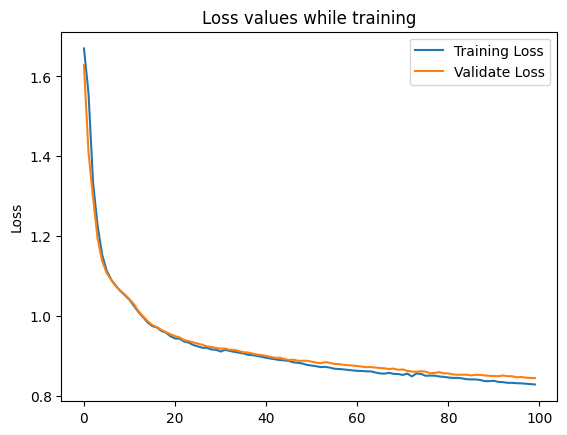

In [38]:
model.train_data()

In [39]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix


y_pred = model.predict(val.X)

accuracy = accuracy_score(val.y,y_pred)
print(f"Accuracy {accuracy}")

conf_matrix = confusion_matrix(val.y, y_pred)
class_wise_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

for i in range(6):
  print(f'Class{i+1} precision:  {class_wise_accuracy[i]} ')

f1_avg = f1_score(val.y, y_pred, average='weighted')
print("F1 Score:", f1_avg)

Accuracy 0.6752827140549273
Class1 precision:  0.6377473363774734 
Class2 precision:  0.6273984828201695 
Class3 precision:  0.8523564064801178 
Class4 precision:  0.5839973439575034 
Class5 precision:  0.7150635208711433 
Class6 precision:  0.5270440251572327 
F1 Score: 0.6778530324837071


### Model with 2 hiden layer and 32 nodes

In [40]:
model = NNClassifier(2,32,100)
print(model)

NNClassifier(
  (model): Sequential(
    (0): Linear(in_features=300, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=6, bias=True)
  )
)


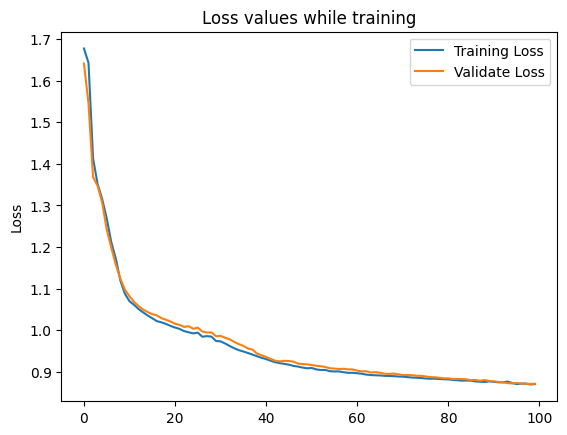

In [41]:
model.train_data()

In [42]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix


y_pred = model.predict(val.X)

accuracy = accuracy_score(val.y,y_pred)
print(f"Accuracy {accuracy}")

conf_matrix = confusion_matrix(val.y, y_pred)
class_wise_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

for i in range(6):
  print(f'Class{i+1} precision:  {class_wise_accuracy[i]} ')

f1_avg = f1_score(val.y, y_pred, average='weighted')
print("F1 Score:", f1_avg)

Accuracy 0.651525230447591
Class1 precision:  0.7899543378995434 
Class2 precision:  0.6091030789825971 
Class3 precision:  0.7614138438880707 
Class4 precision:  0.6789508632138114 
Class5 precision:  0.6252268602540835 
Class6 precision:  0.2138364779874214 
F1 Score: 0.6542390897669065


### Model with 2 hiden layer and 64 nodes

In [43]:
model = NNClassifier(2,64,100)
print(model)

NNClassifier(
  (model): Sequential(
    (0): Linear(in_features=300, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=6, bias=True)
  )
)


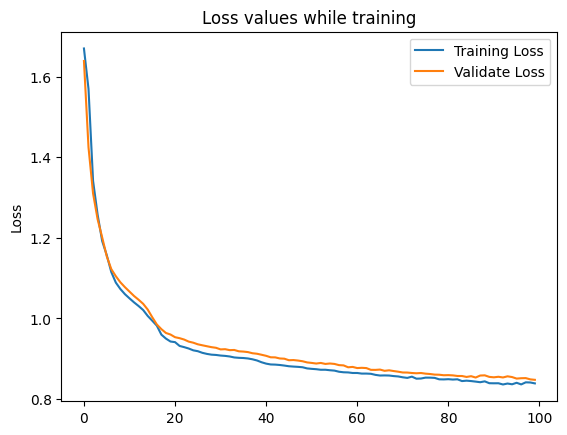

In [44]:
model.train_data()

In [45]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix


y_pred = model.predict(val.X)

accuracy = accuracy_score(val.y,y_pred)
print(f"Accuracy {accuracy}")

conf_matrix = confusion_matrix(val.y, y_pred)
class_wise_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

for i in range(6):
  print(f'Class{i+1} precision:  {class_wise_accuracy[i]} ')

f1_avg = f1_score(val.y, y_pred, average='weighted')
print("F1 Score:", f1_avg)

Accuracy 0.6353701415946023
Class1 precision:  0.8751902587519026 
Class2 precision:  0.5635876840696118 
Class3 precision:  0.719440353460972 
Class4 precision:  0.6553784860557769 
Class5 precision:  0.7041742286751361 
Class6 precision:  0.1811320754716981 
F1 Score: 0.6428989324851305


We can see that this model gives the best result when doing 1 layer of 64 nodes. This could be because of overfitting. Although it seems at first that it would be the best option to put more nodes and more layers to make the model train better with more weights, this data seems to be really sensible to overfitting, so with one layer and 64 nodes would be the best option for it.

## Final model

In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import torch.nn.functional

class NNFinal(nn.Module):
    def __init__(self, layers, nodes, epochs, lr, weights):
        super().__init__()
        self.epochs = epochs
        self.lr = lr
        self.weigths = weights


        self.rnn = nn.LSTM(input_size=300, hidden_size=nodes, num_layers=layers, batch_first=True)
        self.linear = nn.Linear(nodes, 6)

    def forward(self, x):
        output, hidden = self.rnn(x)
        last_output = output[:, :]
        x = self.linear(last_output)
        return x

    def fit(self):
        weights = self.weigths
        weights_tensor = torch.tensor(weights)
        loss_fn = nn.CrossEntropyLoss(weight=weights_tensor)
        optimizer = optim.Adam(model.parameters(), lr=self.lr)

        batch_size = math.ceil(len(train) / self.epochs)
        train_dl = DataLoader(train,batch_size)

        list_loss = []
        list_val = []
        self.train()
        for i in range(self.epochs):
            loss = 0

            for d,lb in train_dl:
              optimizer.zero_grad()

              pred = self(d)
              loss_i = loss_fn(pred, lb-1)
              loss_i.backward()
              optimizer.step()
              loss += loss_i.item() * d.size(0)

            loss = loss / len(train_dl.dataset)
            list_loss.append(loss)

            loss = 0

            batch_size = math.ceil(len(val) / self.epochs)
            val_dl = DataLoader(val,batch_size)

            for d,lb in val_dl:
              optimizer.zero_grad()

              pred = self(d)
              loss_i = loss_fn(pred, lb-1)
              loss_i.backward()
              optimizer.step()
              loss += loss_i.item() * d.size(0)

            loss = loss / len(val_dl.dataset)
            list_val.append(loss)

        plt.plot(list_loss, label='Training Loss')
        plt.plot(list_val, label='Validate Loss')
        plt.xlabel('Epoch number')
        plt.ylabel('Loss')
        plt.title('Loss values while training')
        plt.legend()
        plt.show()


    def predict(self,data):
        with torch.no_grad():
          y_pred = self(data)
          prob = torch.nn.functional.softmax(y_pred, dim=1)

          a, y_pred_prev = torch.max(prob, 1)
          y_pred = []

          for x in y_pred_prev:
              y_pred.append(x + 1)

        return y_pred

In [47]:
weights = [2.0,1.5,0.5,1.0,1.5,4]

model = NNFinal(1,64,75, 0.004, weights)
print(model)

NNFinal(
  (rnn): LSTM(300, 64, batch_first=True)
  (linear): Linear(in_features=64, out_features=6, bias=True)
)


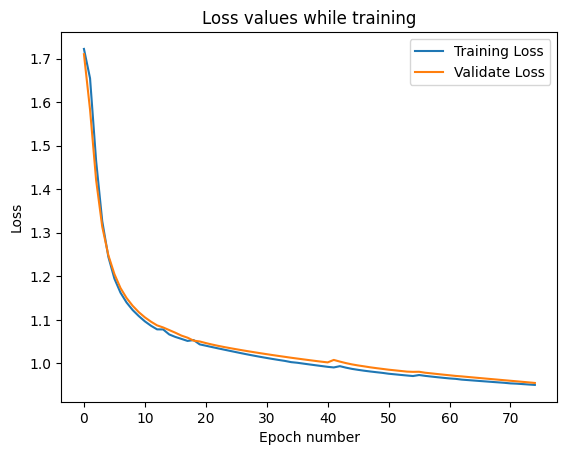

In [48]:
model.fit()

In [49]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix


y_pred = model.predict(val.X)

accuracy = accuracy_score(val.y,y_pred)
print(f"Accuracy {accuracy}")

conf_matrix = confusion_matrix(val.y, y_pred)
class_wise_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

for i in range(6):
  print(f'Class{i+1} precision:  {class_wise_accuracy[i]} ')

f1_avg = f1_score(val.y, y_pred, average='weighted')
print("F1 Score:", f1_avg)

Accuracy 0.6832652285469923
Class1 precision:  0.6681887366818874 
Class2 precision:  0.6983489513609995 
Class3 precision:  0.7963917525773195 
Class4 precision:  0.6414342629482072 
Class5 precision:  0.7114337568058077 
Class6 precision:  0.38616352201257864 
F1 Score: 0.6824646574301947


## Final model structure

As we saw before, we are using the best value for the layers and the nodes in each one, because is the one giving the most accurated results to the predictions. Also, the structure for the layers of this final model is the following:

   Input -> LSTM -> Linear -> Softmax -> Output

Where the input is the value of each of the 300 features, and the output is formed by 6 values, that classify into the different 6 classes. The type of layers that I used are LSTM layers (not having in count the last one) , because RNN layers could classify better this problem than  the linear ones, but also this layers solve the problem of RNN with the gradient between classes. Also, when doing the predictions there is a softmax that decides which final value is going to be the one predicted for all inputs.

At last, I saw when doing the data exploration that the classes are pretty unbalanced, so I decided to give a weight to each class in my model, that indicates which class has to get more importance with the given training data. This could make a big difference on the result of the training preocess.


## Predict train for submission

In [51]:
import csv
y_pred = model.predict(test)

test_pred = list()
for x in y_pred:
  test_pred.append(x.item())

data = [(i, label) for i, label in enumerate(test_pred)]

# Escribir los datos en un archivo CSV
with open('predictions.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['ID', 'label'])
    writer.writerows(data)

## What could be done to improve more?


If additional time and resources were available, I would prioritize optimizing the hyperparameters of the model to improve its performance. This optimization would consist of adjusting the class weights to correct for imbalances in the data set and experimenting with different combinations to improve overall accuracy.

In addition, I would explore the optimal learning rate and number of epochs using techniques such as grid search or random search, with the goal of finding a balance between learnability and overfitting avoidance.

In addition, I would consider exploring other hyperparameters such as LSTM layer configurations, dropout rates, and optimizer parameters to further refine the model. Using techniques such as cross-validation would help ensure the robustness of the model and its generalizability to different subsets of data. However, resource constraints would force careful consideration of computational costs, with priority given to optimizations that offer the most significant performance improvements relative to the resource investment.